In [1]:
import numpy as np

In [2]:
import matplotlib.pylab as plt
%matplotlib inline

In [3]:
import matplotlib.patches as patches
def plot_rectangle(rec, ax=None):
    if ax is None: 
        ax = plt.subplot(aspect='equal')
    
    if isinstance(rec, (list, tuple)):
        for r in rec: 
            plot_rectangle(r,ax)
    
    else:
        size = (rec.maxes-rec.mins)
        ax.add_patch(patches.Rectangle(rec.mins, size[0], size[1], fill=False, zorder=-1))
    
    

In [4]:
#diff = np.float32(0.033068776)
diff = np.float32(0.03306878)
global_min = -31*diff
global_max = 31*diff

dom_maxs = np.array([global_max]*3, dtype=np.float64)
dom_mins = np.array([global_min]*3, dtype=np.float64)
tau = 0.2/12600 # 0.2 times mean interparticle separation
#buffer_tau = diff*5./150.
Ngrid = 62

In [5]:
import sparkhpc

In [6]:
ncores = 8
minblock = 30
maxblock = 32

In [7]:
import os
os.environ['SPARK_HOME'] = '/cluster/home/roskarr/spark'
os.environ['SPARK_DRIVER_MEMORY'] = '16G'

In [8]:
import findspark
findspark.init()

In [9]:
import sparkhpc

In [38]:
sj = sparkhpc.sparkjob.LSFSparkJob(ncores=ncores,memory=16000,walltime='02:00', template='../run_scripts/job.template')

In [39]:
sj.submit()

INFO:sparkhpc:Submitted cluster 0


In [11]:
#sj = sparkhpc.sparkjob.LSFSparkJob(clusterid=0)

In [12]:
sj.wait_to_start()

INFO:sparkhpc:Submitted cluster 1


In [15]:
sc = sparkhpc.start_spark(master=sj.master_url, spark_conf='../conf', 
                          profiling=False, executor_memory='6000M', graphframes_package='graphframes:graphframes:0.3.0-spark2.0-s_2.11')

In [16]:
sc.setCheckpointDir('file:///cluster/home/roskarr/work/euclid')

In [21]:
import spark_fof
path = '/cluster/home/roskarr/projects/euclid/2Tlc-final/'

nMinMembers = 8
nBins = 62
fof_analyzer = spark_fof.spark_fof.LCFOFAnalyzer(sc, path, nMinMembers, nBins, tau, dom_mins, dom_maxs, blockids=range(32,34), buffer_tau=tau*2)

spark_fof: Number of input files:  8
spark_fof: Total number of particles:  587910375


In [ ]:
# fof_analyzer.partitioned_rdd.flatMap(lambda p: p[np.where(p['iOrder'] == 458000793)]).collect()

In [22]:
fof_analyzer.fof_rdd.cache()

PythonRDD[22] at RDD at PythonRDD.scala:48

In [23]:
fof_analyzer.final_fof_rdd.cache()

spark_fof <timing>: domain group mapping build took 381.830840 seconds
total groups:  3075818
spark_fof: Final group map build took 2.538857 seconds


PythonRDD[305] at RDD at PythonRDD.scala:48

In [24]:
len(fof_analyzer.groups)

3075818

In [25]:
%time p1 = np.load('../tests/testdata/fof_32_34_min8.npy')

#from glob import glob


# gids, count = np.unique(p1['iGroup'], return_counts=True)

# count.argsort()[::-1]

# g1 = p1[np.where(p1['iGroup'] == 721691)[0]]

# plt.plot(g1['pos'][:,0],g1['pos'][:,2], '.', alpha=.01)

CPU times: user 29 ms, sys: 16 s, total: 16 s
Wall time: 1min 54s


In [26]:
len(p1)

587910375

In [27]:
group_counts = np.bincount(p1['iGroup'])

In [28]:
len(group_counts)-1

3075818

In [29]:
group_count_counts = np.bincount(group_counts[1:])

In [30]:
group_count_arr = np.array([y for x,y in fof_analyzer.total_group_counts])
group_count_counts2 = np.bincount(group_count_arr)

In [31]:
np.all(group_count_counts==group_count_counts2)

True

In [34]:
group_counts.sum()

587910375

In [35]:
np.save('../tests/testdata/fof_32_34_min8_groups.npy', group_counts)

In [32]:
sj.stop()

INFO:sparkhpc:Job <38435036> is being terminated



In [33]:
p1[np.where(p1['iGroup']==1104259)][0]

([-0.03315236419439316, -0.008246643468737602, -0.05857064202427864], 0, 221965232, <read-write buffer ptr 0x354c6f64, size 4 at 0x2aea2f79de70>, 1104259)

In [34]:
groupid_sp = fof_analyzer.final_fof_rdd.flatMap(lambda p: p[np.where(p['iOrder'] == 221965232)]).first()['iGroup']

In [40]:
for groupid in np.where(group_counts==1749)[0]:
    g = p1[np.where(p1['iGroup']==groupid)]
    groupid_sp = fof_analyzer.final_fof_rdd.flatMap(lambda p: p[np.where(p['iOrder'] == g[0]['iOrder'])[0]]).collect()[0]['iGroup']
    g_sp = np.array(fof_analyzer.final_fof_rdd.flatMap(lambda p: p[np.where(p['iGroup'] == groupid_sp)[0]]).collect())
    print groupid, groupid_sp, len(g), len(g_sp)
#     missing = np.where(~np.in1d(g['iOrder'],g_sp['iOrder']))[0]
#     if len(missing) == 0: 
#         missing = np.where(~np.in1d(g_sp['iOrder'],g['iOrder']))[0]
#     if len(missing) != 0: 
#         print 'found error in g_sp = ', g_sp

253628 308264 1749 1749
276298 327034 1749 1749
471383 456281 1749 1749
512850 657986 1749 1749
686298 672009 1749 1749
975985 847589 1749 1749
1085992 1019064 1749 1749
1104259 3077799 1749 1745
1437204 1316057 1749 1749
1491285 1458867 1749 1749
1761844 1581202 1749 1749
1895107 1834496 1749 1749
2171417 2050556 1749 1749
2242639 2148452 1749 1749
2966142 2998731 1749 1749
3032623 2871039 1749 1749


In [35]:
g = np.array(fof_analyzer.final_fof_rdd.flatMap(lambda p: p[np.where(p['iGroup'] == groupid_sp)[0]]).collect())

In [30]:
g1 = p1[np.where(p1['iGroup'] == 1104259)]

In [31]:
g1['iOrder']

array([221965232, 221965236, 221965237, ..., 458006612, 458006613,
       458006614], dtype=int32)

In [36]:
g['iOrder']

array([221965232, 221965236, 221965237, ..., 458006612, 458006613,
       458006614])

In [37]:
missing = g1[np.where(~np.in1d(g1['iOrder'],g['iOrder']))[0]]

In [38]:
missing_rect = [spark_fof.spark_fof_c.get_bin_wrapper(missing[i]['pos'], 62, fof_analyzer.dom_mins, fof_analyzer.dom_maxs) for i in range(len(missing))]

In [39]:
missing

array([ ([-0.03307649865746498, -0.008163860067725182, -0.05856410413980484], 0, 221966013, <read-write buffer ptr 0x1b61bf84, size 4 at 0x2aea2f79d5b0>, 1104259),
       ([-0.03306760638952255, -0.008158876560628414, -0.05856703594326973], 0, 458000791, <read-write buffer ptr 0x1b61bfa4, size 4 at 0x2aea2f79d5b0>, 1104259),
       ([-0.03305890038609505, -0.00816462840884924, -0.05855857580900192], 0, 458000792, <read-write buffer ptr 0x1b61bfc4, size 4 at 0x2aea2f79d5b0>, 1104259),
       ([-0.03306877985596657, -0.008160539902746677, -0.05855977535247803], 0, 458000793, <read-write buffer ptr 0x1b61bfe4, size 4 at 0x2aea2f79d9f0>, 1104259)], 
      dtype=[('pos', '<f4', (3,)), ('is_ghost', '<i4'), ('iOrder', '<i4'), ('f3', 'V4'), ('iGroup', '<i8')])

In [40]:
missing_rect

[113365, 113366, 113366, 113365]

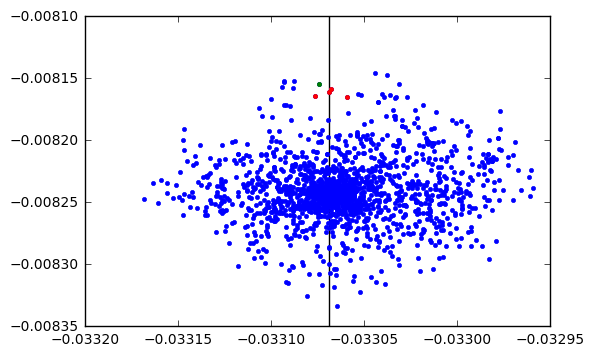

In [119]:
f,ax = plt.subplots()

x=0
y=1

ax.plot(g1['pos'][:,x],g1['pos'][:,y],'.')
ax.plot(missing['pos'][:,x],missing['pos'][:,y],'r.')
ax.plot(link_p['pos'][0,x], link_p['pos'][0,y], '.')
plot_rectangle(fof_analyzer.domain_containers[missing_rect[0]],ax)
plot_rectangle(fof_analyzer.domain_containers[missing_rect[1]].bufferRectangle,ax)
plot_rectangle(fof_analyzer.domain_containers[113366].bufferRectangle,ax)
#plt.xlim(-0.0331,-0.0329)
# plt.ylim(-0.0331,-0.03305)

In [39]:
batch_size = 1024*10240
def filter_partition(pid, iterator):
    if pid == 6: 
        arr = np.concatenate(list(iterator))
        np.save('/cluster/home/roskarr/Projects/spark-fof/debug_data/part_6',arr)
        yield 1
    yield 0

In [222]:
fof_analyzer.partitioned_rdd.mapPartitionsWithIndex(filter_partition).collect()

[0, 0, 0, 0, 0, 0, 1, 0, 0]

In [44]:
part_2 = np.load('../debug_data/part_2.npy')

In [45]:
missing2 = g1[np.where(~np.in1d(g1['iOrder'],part_2['iOrder']))[0]]

In [46]:
missing2

array([ ([-0.03306877985596657, -0.008160539902746677, -0.05855977535247803], 0, 458000793, <read-write buffer ptr 0x198249a4, size 4 at 0x2aea710c02b0>, 1104259)], 
      dtype=[('pos', '<f4', (3,)), ('is_ghost', '<i4'), ('iOrder', '<i4'), ('f3', 'V4'), ('iGroup', '<i8')])

In [63]:
import scipy
d = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(g1['pos']))/tau

In [64]:
miss_ind = np.where(g1['iOrder'] ==458000793 )[0]

In [89]:
dmiss = d[miss_ind].squeeze()

In [94]:
nearest = dmiss.argsort()[1:8]

In [97]:
zip(dmiss[nearest],g1[nearest]['iOrder'])

[(0.47505471199144561, 458000791),
 (0.59548095818721658, 221966013),
 (0.67782470190692079, 458000792),
 (0.79282656789454942, 221966018),
 (1.3471609485191982, 221966015),
 (1.5102245295454979, 221966012),
 (1.5488629469838175, 221969933)]

below is the list of missing particles -- in the distributed FOF, these four are the only ones that appear on each others' lists -- whereis 221966018? It should be at least grouped with 458000793.

In [96]:
missing

array([ ([-0.03307649865746498, -0.008163860067725182, -0.05856410413980484], 0, 221966013, <read-write buffer ptr 0x1b61bf84, size 4 at 0x2aea7746aa70>, 1104259),
       ([-0.03306760638952255, -0.008158876560628414, -0.05856703594326973], 0, 458000791, <read-write buffer ptr 0x1b61bfa4, size 4 at 0x2aea7746aa70>, 1104259),
       ([-0.03305890038609505, -0.00816462840884924, -0.05855857580900192], 0, 458000792, <read-write buffer ptr 0x1b61bfc4, size 4 at 0x2aea7746aa70>, 1104259),
       ([-0.03306877985596657, -0.008160539902746677, -0.05855977535247803], 0, 458000793, <read-write buffer ptr 0x1b61bfe4, size 4 at 0x2aea7746ab30>, 1104259)], 
      dtype=[('pos', '<f4', (3,)), ('is_ghost', '<i4'), ('iOrder', '<i4'), ('f3', 'V4'), ('iGroup', '<i8')])

In [107]:
link_p = np.array(fof_analyzer.final_fof_rdd.flatMap(lambda p: p[np.where(p['iOrder']==221966018)[0]]).collect())

In [108]:
link_p

array([ ([-0.03307422623038292, -0.008154651150107384, -0.05855007842183113], 0, 221966018, 3078210)], 
      dtype={'names':['pos','is_ghost','iOrder','iGroup'], 'formats':[('<f4', (3,)),'<i4','<i8','<i8'], 'offsets':[0,12,16,24], 'itemsize':32, 'aligned':True})

In [113]:
spark_fof.spark_fof_c.get_bin_wrapper(link_p['pos'][0], 62, fof_analyzer.dom_mins, fof_analyzer.dom_maxs)

113365

In [114]:
fof_analyzer.global_to_local_map

{113303: 0,
 113304: 4,
 113365: 2,
 113366: 6,
 117147: 1,
 117148: 5,
 117209: 3,
 117210: 7}

In [122]:
np.where(part_2['iOrder'] == 221966018)

(array([68496724]),)

In [124]:
missing[3]

([-0.03306877985596657, -0.008160539902746677, -0.05855977535247803], 0, 458000793, <read-write buffer ptr 0x1b61bfe4, size 4 at 0x2aea5f625ab0>, 1104259)

In [125]:
missing[3]['pos'][0]

-0.03306878

In [126]:
fof_analyzer.domain_containers[113365].maxes

array([-0.03306878,  0.        , -0.03306878])

In [127]:
fof_analyzer.domain_containers[113366].mins

array([-0.03306878, -0.03306878, -0.06613755])

In [136]:
def filter_partition(i,it): 
    if i == 1: 
        for x in it: 
            yield x

In [137]:
fof_analyzer.particle_rdd.mapPartitionsWithIndex(filter_partition).first()

array([ ([-0.0658622533082962, -0.06613367795944214, -0.03302016481757164], 1, 78680370, 1),
       ([-0.06585754454135895, -0.06598768383264542, -0.03282991424202919], 1, 78680371, 1),
       ([-0.06611359119415283, -0.06601326912641525, -0.032792527228593826], 1, 78680372, 1),
       ...,
       ([-0.06546000391244888, -0.06489897519350052, -0.0037605660036206245], 0, 78782767, 1),
       ([-0.06548574566841125, -0.06494861096143723, -0.0037271305918693542], 0, 78782768, 1),
       ([-0.06538194417953491, -0.06481509655714035, -0.003577240277081728], 0, 78782769, 1)], 
      dtype={'names':['pos','is_ghost','iOrder','iGroup'], 'formats':[('<f4', (3,)),'<i4','<i8','<i8'], 'offsets':[0,12,16,24], 'itemsize':32, 'aligned':True})

In [141]:
fof_analyzer.domain_containers[113365].mins[0] <= missing[3]['pos'][0] < fof_analyzer.domain_containers[113365].maxes[0]

True

In [142]:
fof_analyzer.ids_map

{(30, 30, 30): 0,
 (30, 30, 31): 1,
 (30, 31, 30): 2,
 (30, 31, 31): 3,
 (31, 30, 30): 4,
 (31, 30, 31): 5,
 (31, 31, 30): 6,
 (31, 31, 31): 7}

In [134]:
fof_analyzer.domain_containers[113365].maxes[0]

-0.03306877613067627

In [65]:
part_6 = np.load('../debug_data/part_6.npy')

In [68]:
part_6['pos'][:,2].max() - part_6['pos'][:,2].min()

0.034171037

In [61]:
np.where(part_6['iOrder'] == 458000793)

(array([2217887]),)

In [69]:
part_6[np.where(part_6['iOrder'] == 458000793)]

array([ ([-0.03306877985596657, -0.008160539902746677, -0.05855977535247803], 0, 458000793, 5913175)], 
      dtype=[('pos', '<f4', (3,)), ('is_ghost', '<i4'), ('iOrder', '<i8'), ('iGroup', '<i8')])

In [65]:
spark_fof.spark_fof_c.get_bin_wrapper(part_6[2217887]['pos'] - np.array([0, 0,0], dtype=np.float32), 62, fof_analyzer.dom_mins, fof_analyzer.dom_maxs)

113365

In [66]:
fof_analyzer.domain_containers[113366]

<DomainRectangle [(-0.03306877613067627, 0.0), (-0.03306877613067627, 0.0), (-0.066137552261352539, -0.03306877613067627)]>

In [67]:
spark_fof.fof.run(part_6, tau, 1)

30221958

In [68]:
part_6[2217887]

([-0.03294648602604866, -0.0036082144360989332, -0.03941119462251663], 1, 458445475, 21531255)

In [71]:
part_6[np.where(part_6['iGroup'] == 5913175)]

array([ ([-0.03306760638952255, -0.008158876560628414, -0.05856703594326973], 1, 458000791, 5913175),
       ([-0.03305890038609505, -0.00816462840884924, -0.05855857580900192], 1, 458000792, 5913175),
       ([-0.03306877985596657, -0.008160539902746677, -0.05855977535247803], 0, 458000793, 5913175)], 
      dtype=[('pos', '<f4', (3,)), ('is_ghost', '<i4'), ('iOrder', '<i8'), ('iGroup', '<i8')])

### Figure out which particles from 31,30,31 are supposed to be in 'big group'

In [27]:
big_group = np.concatenate(fof_analyzer.fof_rdd.map(lambda p: p[np.where((p['iGroup'] == 4318953668))[0]]).collect())

In [28]:
fof_analyzer.domain_containers[map_file_to_domain((31,30,31))]

<DomainRectangle [(-0.03306877613067627, 0.0), (-0.066137552261352539, -0.03306877613067627), (-0.03306877613067627, 0.0)]>

In [31]:
big_group['pos'][:,0].max()

-0.033068791

In [32]:
fof_analyzer.buffer_tau

0.0011022925376892091

In [33]:
g1_temp = np.zeros(len(g1), dtype=spark_fof.spark_fof_c.pdt)

In [34]:
g1_temp['pos'] = g1['pos']
g1_temp['iOrder'] = g1['iOrder']
g1_temp['iGroup'] = g1['iGroup']

In [35]:
spark_fof.spark_fof_c.ghost_mask(g1_temp, tau, Ngrid, 
                                 fof_analyzer.container_mins, fof_analyzer.container_maxs, 
                                 fof_analyzer.buff_mins, fof_analyzer.buff_maxs,
                                 fof_analyzer.dom_mins, fof_analyzer.dom_maxs)

In [36]:
g1_ghosts = g1_temp[np.where(g1_temp['is_ghost'])[0]]

In [42]:
g1_conj = g1[(np.where(
                                    (g1['pos'][:,0] > -0.03306878) &
                                    (g1['pos'][:,0] < -0.0325) &
                                    (g1['pos'][:,1] > -0.047) &
                                    (g1['pos'][:,1] < -0.0454) &
                                    (g1['pos'][:,2] > -0.003) &
                                    (g1['pos'][:,2] < 0))[0])]

In [43]:
g1_conj['iOrder'][:-20]

array([380603902, 380603904, 380603908, ..., 381094370, 381094371,
       381094372], dtype=int32)

In [37]:
fof_analyzer.fof_rdd.flatMap(lambda p: p[np.where(p['iOrder']==381094372)]).collect()

[([-0.03250090777873993, -0.046229396015405655, -4.9006888730218634e-05], 0, 381094372, 21495396425)]

In [111]:
big_group_conj = fof_analyzer.fof_rdd.flatMap(lambda p: p[np.where(p['iGroup']==12900170818)]).collect()

In [112]:
big_group_conj = np.array(big_group_conj)

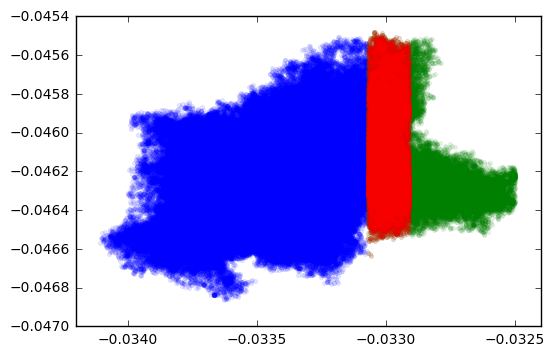

In [44]:
plt.plot(big_group['pos'][:,0], big_group['pos'][:,1], '.', alpha=.1)
plt.plot(g1_conj['pos'][:,0], g1_conj['pos'][:,1], '.', alpha=.1)
plt.plot(g1_ghosts['pos'][:,0], g1_ghosts['pos'][:,1], '.', alpha=.1)
# plt.plot([-0.03306878,-0.03306878], [-.047,-.0454])
# plt.xlim(-0.0332,-0.033)

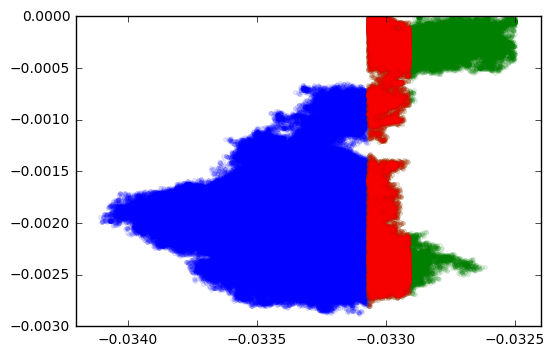

In [45]:
plt.plot(big_group['pos'][:,0], big_group['pos'][:,2], '.', alpha=.1)
plt.plot(g1_conj['pos'][:,0], g1_conj['pos'][:,2], '.', alpha=.1)
plt.plot(g1_ghosts['pos'][:,0], g1_ghosts['pos'][:,2], '.', alpha=0.1)
# plt.plot([-0.03306878,-0.03306878], [-.047,-.0454])
# plt.xlim(-0.0332,-0.033)

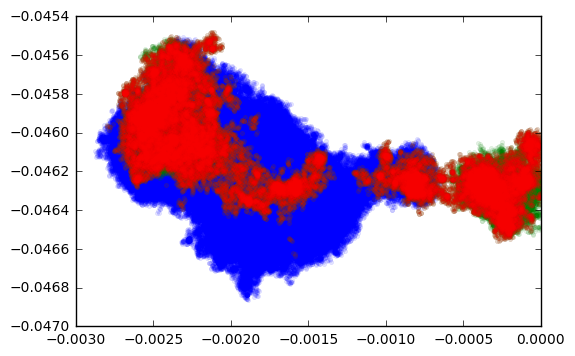

In [46]:
plt.plot(big_group['pos'][:,2], big_group['pos'][:,1], '.', alpha=.1)
plt.plot(g1_conj['pos'][:,2], g1_conj['pos'][:,1], '.', alpha=.1)
plt.plot(g1_ghosts['pos'][:,2], g1_ghosts['pos'][:,1], '.', alpha=0.1)
# plt.plot([-0.03306878,-0.03306878], [-.047,-.0454])
# plt.xlim(-0.0332,-0.033)

In [47]:
%time len(np.where(np.in1d(g1['iOrder'], g1_ghosts['iOrder']))[0])

CPU times: user 42 ms, sys: 6 ms, total: 48 ms
Wall time: 47.8 ms


44480

In [48]:
def filter_partition(partition_index, iterator): 
    for arr in iterator: 
        yield (partition_index, arr[np.where(np.in1d(arr['iOrder'], g1_ghosts['iOrder']))])

In [49]:
ghosts2 = fof_analyzer.fof_rdd.mapPartitionsWithIndex(filter_partition).collect()

In [50]:
ghosts2 = [(i,j) for i,j in ghosts2 if len(j)>0]

In [51]:
ghosts2

[(3,
  array([ ([-0.03304780274629593, -0.046373866498470306, -0.0023223136086016893], 2, 380603902, 12892767316),
         ([-0.033042553812265396, -0.046378765255212784, -0.0023234838154166937], 2, 380603904, 12892767316),
         ([-0.03306576609611511, -0.046372078359127045, -0.0023417100310325623], 2, 380603908, 12892767316),
         ...,
         ([-0.032913316041231155, -0.04621169716119766, -0.00028125380049459636], 2, 381084772, 12892767135),
         ([-0.03291759267449379, -0.0462479442358017, -0.0002497878740541637], 2, 381084780, 12892767135),
         ([-0.0329991839826107, -0.04619506746530533, -0.00031390044023282826], 2, 381093683, 12892767135)], 
        dtype={'names':['pos','is_ghost','iOrder','iGroup'], 'formats':[('<f4', (3,)),'<i4','<i8','<i8'], 'offsets':[0,12,16,24], 'itemsize':32, 'aligned':True})),
 (5,
  array([ ([-0.03304780274629593, -0.046373866498470306, -0.0023223136086016893], 1, 380603902, 21495397267),
         ([-0.033042553812265396, -0.046378765

In [65]:
pos = np.array([-0.03304780274629593-buffer_tau, -0.046373866498470306, -0.0023223136086016893], dtype=np.float32)

spark_fof.spark_fof_c.get_bin_wrapper(pos, 62, fof_analyzer.dom_mins, fof_analyzer.dom_maxs)

117147

In [70]:
g2_copy = ghosts2[1][1].copy()

In [71]:
res = spark_fof.spark_fof_c.partition_ghosts(g2_copy, 62, buffer_tau, False, fof_analyzer.dom_mins, fof_analyzer.dom_maxs)

In [72]:
res

[(117147,
  array([ ([-0.032958984375, -0.046205148100852966, -0.002642377046868205], 2, 380994948, 117147),
         ([-0.03296184539794922, -0.046236440539360046, -0.00040352376527152956], 2, 381050132, 117147),
         ([-0.03296184539794922, -0.045742493122816086, -0.0023554344661533833], 2, 381005367, 117147),
         ...,
         ([-0.032958026975393295, -0.046079669147729874, -0.002379882847890258], 2, 380999266, 117147),
         ([-0.032958026975393295, -0.045945703983306885, -0.002591261873021722], 2, 381000885, 117147),
         ([-0.0329589806497097, -0.046243272721767426, -0.0004218681715428829], 2, 381050116, 117147)], 
        dtype=[('pos', '<f4', (3,)), ('is_ghost', '<i4'), ('iOrder', '<i8'), ('iGroup', '<i8')]))]

In [52]:
fof_analyzer.global_to_local_map

{113303: 0,
 113304: 4,
 113365: 2,
 113366: 6,
 117147: 1,
 117148: 5,
 117209: 3,
 117210: 7}

In [100]:
ghosts_rdd = (fof_analyzer._partition_rdd(fof_analyzer.particle_rdd, spark_fof.spark_fof_c.partition_ghosts)
                          .filter(lambda (k,v): k in gl_to_loc)
                          .map(lambda (k,v): (gl_to_loc[k],v))
                          .partitionBy(8))
#                          .map(lambda (k,v): remap_partition(v), preservesPartitioning=True))

In [102]:
ghosts_rdd.values().mapPartitionsWithIndex(filter_partition).filter(lambda (k,v): len(v)>0).first()

(1,
 array([ ([-0.03297233581542969, -0.046368759125471115, -0.0002343545638723299], 2, 380662174, 117147),
        ([-0.03297710418701172, -0.04632404446601868, -0.00039219940663315356], 2, 380656196, 117147),
        ([-0.032990455627441406, -0.04635351151227951, -0.0019101909128949046], 2, 380637535, 117147),
        ...,
        ([-0.0329437218606472, -0.046461641788482666, -0.0002736372116487473], 2, 380660387, 117147),
        ([-0.032945629209280014, -0.04630206525325775, -0.00038568503805436194], 2, 380657121, 117147),
        ([-0.03295135125517845, -0.04632473737001419, -0.0003207860281690955], 2, 380672791, 117147)], 
       dtype=[('pos', '<f4', (3,)), ('is_ghost', '<i4'), ('iOrder', '<i8'), ('iGroup', '<i8')]))

In [104]:
fof_analyzer.partitioned_rdd.first()

array([ ([-0.03296089172363281, -0.03279634565114975, -0.040982604026794434], 2, 456261736, 113304),
       ([-0.03247356414794922, -0.032977331429719925, -0.04245378077030182], 2, 456258729, 113304),
       ([-0.03296184539794922, -0.03281840309500694, -0.04093220829963684], 2, 456262109, 113304),
       ...,
       ([-0.03294658288359642, -0.0324300080537796, -0.05982505902647972], 2, 456239794, 113304),
       ([-0.03294849023222923, -0.03215708211064339, -0.04066157713532448], 2, 456264267, 113304),
       ([-0.03246116265654564, -0.03221967816352844, -0.0661061629652977], 2, 456228189, 113304)], 
      dtype=[('pos', '<f4', (3,)), ('is_ghost', '<i4'), ('iOrder', '<i8'), ('iGroup', '<i8')])

In [115]:
ghosts_rdd.partitioner.partitionFunc

<function pyspark.rdd.portable_hash>

In [112]:
ghosts_rdd

MapPartitionsRDD[48] at mapPartitions at PythonRDD.scala:422

In [114]:
fof_analyzer.particle_rdd.partitioner.partitionFunc

<function pyspark.rdd.portable_hash>

In [76]:
gl_to_loc=fof_analyzer.global_to_local_map

In [88]:
x = ghosts_rdd.filter(lambda (k,v): k == 117147).first()[1]

In [85]:
spark_fof.spark_fof_c.remap_gid_partition_cython(x, gl_to_loc)

In [87]:
def remap_partition(particles):
    """Helper function to remap groups"""
    spark_fof.spark_fof_c.remap_gid_partition_cython(particles, gl_to_loc)
    return particles

In [89]:
remap_partition(x)

array([ ([-0.06592941284179688, -0.033013392239809036, -0.019414184615015984], 2, 222645602, 1),
       ([-0.06497001647949219, -0.033042021095752716, -0.024396952241659164], 2, 222634122, 1),
       ([-0.06546592712402344, -0.03295039013028145, -0.0191720649600029], 2, 222646032, 1),
       ...,
       ([-0.06485556811094284, -0.03306339681148529, -0.011115534231066704], 2, 222656967, 1),
       ([-0.06487273424863815, -0.03305643051862717, -0.011130041442811489], 2, 222656935, 1),
       ([-0.06540297716856003, -0.03302094712853432, -0.030512182042002678], 2, 222611965, 1)], 
      dtype=[('pos', '<f4', (3,)), ('is_ghost', '<i4'), ('iOrder', '<i8'), ('iGroup', '<i8')])

In [96]:
fof_analyzer.partitioned_rdd.mapPartitionsWithIndex(filter_partition).filter(lambda (k,v): len(v)>0).first()

(3,
 array([ ([-0.03297233581542969, -0.046368759125471115, -0.0002343545638723299], 2, 380662174, 117147),
        ([-0.03297710418701172, -0.04632404446601868, -0.00039219940663315356], 2, 380656196, 117147),
        ([-0.032990455627441406, -0.04635351151227951, -0.0019101909128949046], 2, 380637535, 117147),
        ...,
        ([-0.0329437218606472, -0.046461641788482666, -0.0002736372116487473], 2, 380660387, 117147),
        ([-0.032945629209280014, -0.04630206525325775, -0.00038568503805436194], 2, 380657121, 117147),
        ([-0.03295135125517845, -0.04632473737001419, -0.0003207860281690955], 2, 380672791, 117147)], 
       dtype=[('pos', '<f4', (3,)), ('is_ghost', '<i4'), ('iOrder', '<i8'), ('iGroup', '<i8')]))

In [91]:
fof_analyzer.partitioned_rdd.flatMap(lambda p: p[np.where(p['iGroup']>10)[0]]).first()

([-0.03296089172363281, -0.03279634565114975, -0.040982604026794434], 2, 456261736, 113304)

In [80]:
(ghosts_rdd.filter(lambda (k,v): k == 117147)
           .map(lambda (k,v): (gl_to_loc[k],v))
           .values()
           .flatMap(lambda p: p[np.where(p['iOrder'] == 380994948)])).collect()

[([-0.032958984375, -0.046205148100852966, -0.002642377046868205], 2, 380994948, 117147)]

In [83]:
fof_analyzer._partitioned_rdd.flatMap(lambda p: p[np.where(p['iOrder'] == 380994948)]).collect()

[([-0.032958984375, -0.046205148100852966, -0.002642377046868205], 2, 380994948, 117147),
 ([-0.032958984375, -0.046205148100852966, -0.002642377046868205], 1, 380994948, 5)]

In [112]:
fof_analyzer.domain_containers[117209]

<DomainRectangle [(-0.066137552261352539, -0.03306877613067627), (-0.03306877613067627, 0.0), (-0.03306877613067627, 0.0)]>

In [119]:
spark_fof.spark_fof_c.get_bin_wrapper(np.array([-0.03306576609611511-tau*10, -0.046372078359127045-tau*10, -0.0023417100310325623-tau*10], dtype=np.float32), 62, fof_analyzer.dom_mins, fof_analyzer.dom_maxs)

117147

In [84]:
ghosts = fof_analyzer.fof_rdd.flatMap(lambda p: p[np.where(np.in1d(p['iOrder'], g1_ghosts['iOrder']))]).collect()

In [88]:
ghosts = np.array(ghosts)

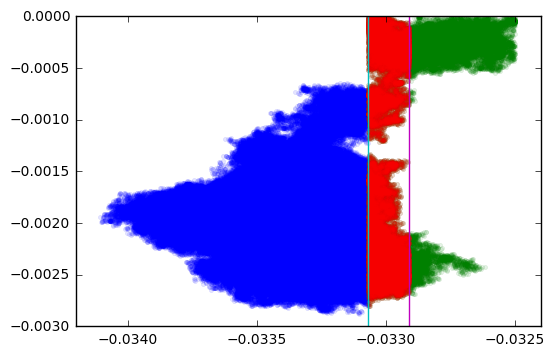

In [53]:
plt.plot(big_group['pos'][:,0], big_group['pos'][:,2], '.', alpha=.1)
plt.plot(g1_conj['pos'][:,0], g1_conj['pos'][:,2], '.', alpha=.1)
plt.plot(ghosts2[0][1]['pos'][:,0], ghosts2[0][1]['pos'][:,2], '.', alpha=0.1)
plt.plot([-0.03306878,-0.03306878], [-.003,0])
plt.plot([-0.03306878+tau*10,-0.03306878+tau*10], [-.003,0])
# plt.xlim(-0.0332,-0.033)

In [95]:
tau*10

0.00015873015873015873

In [67]:
spark_fof.spark_fof_c.partition_ghosts(g1_ghosts, 62, tau, 0, dom_mins, dom_maxs)

[(117147,
  array([ ([-0.03306696563959122, -0.046371471136808395, -0.0023140565026551485], 2, 380636276, 117147),
         ([-0.03306327387690544, -0.0463615320622921, -0.002314580837264657], 2, 380636284, 117147),
         ([-0.033061377704143524, -0.04636291041970253, -0.002334720455110073], 2, 380603921, 117147),
         ([-0.03306146711111069, -0.04635850712656975, -0.0023400457575917244], 2, 380603929, 117147),
         ([-0.03305801376700401, -0.046335168182849884, -0.0023021292872726917], 2, 380636278, 117147),
         ([-0.03306576609611511, -0.046372078359127045, -0.0023417100310325623], 2, 380603908, 117147)], 
        dtype={'names':['pos','is_ghost','iOrder','iGroup'], 'formats':[('<f4', (3,)),'<i4','<i4','<i8'], 'offsets':[0,12,16,24], 'itemsize':32}))]

In [69]:
fof_analyzer.fof_rdd.flatMap(lambda p: p[np.where(p['iOrder'] == 380636276)]).glom().collect()

[[],
 [],
 [],
 [([-0.03306696563959122, -0.046371471136808395, -0.0023140565026551485], 2, 380636276, 12900173241)],
 [],
 [([-0.03306696563959122, -0.046371471136808395, -0.0023140565026551485], 1, 380636276, 21487057823)],
 [],
 []]

In [72]:
spark_fof.spark_fof.get_bin(np.array([-0.03306696563959122, -0.046371471136808395, -0.0023140565026551485], dtype=np.float32), 62, dom_mins, dom_maxs)

117148

In [99]:
p1[np.where(p1['iOrder'] == 380636276)]['iGroup']

array([721691])

In [88]:
sj.stop()

INFO:sparkhpc:Job <37866119> is being terminated

